##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image Embedding with MediaPipe Tasks

This notebook will show you how to use the MediaPipe Tasks Python API to compare two separate image files to determine how similar they are. These values will range from -1 to 1 with 1 being the same image This is done through a technique called cosine similarity.

## Preparation
You can start by installing the necessary dependencies for your project.

Note:



*   *If you see an error about `flatbuffers` incompatibility, it's fine to ignore it. MediaPipe requires a newer version of flatbuffers (v2), which is incompatible with the older version of Tensorflow (v2.9) currently preinstalled on Colab.*

*   *If you install MediaPipe outside of Colab, you only need to run `pip install mediapipe`. It isn't necessary to explicitly install `flatbuffers`.*



In [ ]:
!pip install -q flatbuffers==2.0.0
!pip install -q sounddevice
!pip install -q -i https://test.pypi.org/simple/ mediapipe==0.9.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 16.2 MB/s eta 0:00:00


The next step you will take is to download the off-the-shelf model that will be used for image embedding. In this case you will use mobilenet, but you may use any other appropriate model or a model that you have built for your own specific use-cases with MediaPipe Tasks.

In [ ]:
!wget -O embedder.tflite -q https://storage.googleapis.com/mediapipe-assets/mobilenet_v3_small_100_224_embedder.tflite

For the final preparation step, you will need to have two separate images that can be compared. You can download two provided images through the following code, or you can download your own from a different location.

In [ ]:
import urllib

IMAGE_FILENAMES = ['burger.jpg', 'burger_crop.jpg']

for name in IMAGE_FILENAMES:
  url = f'https://storage.googleapis.com/mediapipe-assets/{name}'
  urllib.request.urlretrieve(url, name)

# Performing Image Embedding
Now that you have retrieved the two images that will be compared, you can display them to confirm that they look correct. For this example you should see two separate, but similar, pictures of burgers.

burger.jpg


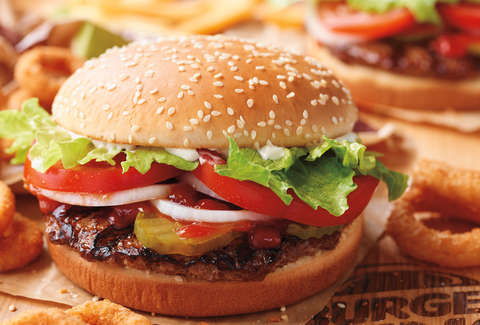

burger_crop.jpg


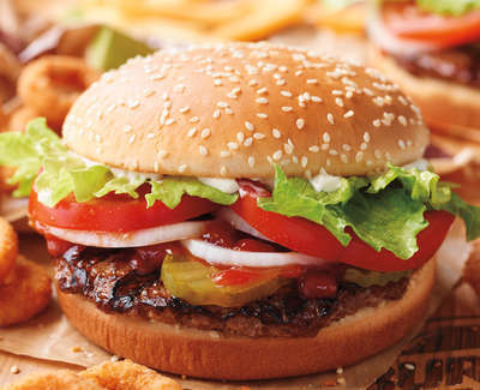

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import math

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)


# Preview the images.
images = {name: cv2.imread(name) for name in IMAGE_FILENAMES}
for name, image in images.items():
  print(name)
  resize_and_show(image)

Once everything looks good, you can start performing inference. You will start by creating the options that are necessary for associating your model with the Image Embedder, as well as some customizations.

Next you will create the Image Embedder, then format your two images for MediaPipe so that you can use cosine similarity to compare them. 

Finally, you will display the similarity value.

In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# Create options for Image Embedder
base_options = python.BaseOptions(model_asset_path='embedder.tflite')
l2_normalize = True #@param {type:"boolean"}
quantize = True #@param {type:"boolean"}
options = vision.ImageEmbedderOptions(
    base_options=base_options, l2_normalize=l2_normalize, quantize=quantize)


# Create Image Embedder
with vision.ImageEmbedder.create_from_options(options) as embedder:

  # Format images for MediaPipe
  first_image = mp.Image.create_from_file(IMAGE_FILENAMES[0])
  second_image = mp.Image.create_from_file(IMAGE_FILENAMES[1])
  first_embedding_result = embedder.embed(first_image)
  second_embedding_result = embedder.embed(second_image)

  # Calculate and print similarity
  similarity = vision.ImageEmbedder.cosine_similarity(
      first_embedding_result.embeddings[0],
      second_embedding_result.embeddings[0])
  print(similarity)

0.9215522112629242
